# Multi-Pitches estimation: Step by Step 
## Geoffroy Peeters - 2018/11

# Introduction

L’objectif de ce TP est de réaliser un module d’estimation de fréquences fondamentales multiples d’un signal de musique (ou encore de déterminer à partir du signal audio les notes de musique jouées).
S’il existe plusieurs approches possibles pour ce problème, il est proposé ici d’étudier une technique simple inspirée par les travaux de A. Klapuri [1, 2].

Cette approche consiste à estimer dans un premier temps la fréquence fondamentale dominante, à en déduire la position et l’amplitude de ses harmoniques sur le spectre puis à soustraire la contribution du son correspondant.
Ce principe est ensuite itéré afin d’extraire l’ensemble des fréquences fondamentales du son initial.
Il est ensuite proposé de mettre en place le principe de la continuité de l’enveloppe spectrale (spectral smoothness) qui sera appliqué au préalable de la soustraction fréquentielle.
Les performances de ces approches seront finalement testées et comparées sur différents accords composés de notes de piano, flute et hautbois.
On travaillera sur des fenêtres de signal d’une durée de 250ms.

La figure résume les différentes étapes de l’algorithme.

<IMG src='./_images/TP_multiPitch_schema.png'  width=800/>

In [1]:
import numpy as np
import scipy.io.wavfile
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import sys
import math
import tpt_tools
%matplotlib inline

#audioFile = './_audio/A3_piano.wav'# 220 Hz 
#audioFile = './_audio/A4_piano.wav' # 440 Hz
#audioFile = './_audio/E4_oboe.wav' # 329 Hz
#audioFile = './_audio/A5_flute.wav' # 880
#audioFile = './_audio/A3A4_piano.wav' # 220, 440
#audioFile = './_audio/A3A4A5_duo.wav' # 220, 440, 880
audioFile = './_audio/A3C4E4G4_piano.wav' # 220, 261, 329, 392 Hz

# for inharmonicity search
Beta = 0.0001

quarter_tone_coef = 2**(1.0/24) -1
Alpha = 0.6 * quarter_tone_coef

sr_hz, data_v = scipy.io.wavfile.read(audioFile)

fmin_hz = 50
fmax_hz = 900
H = 4
L_sec = 0.1
enery_threshold = 0.005
start_sec = 0.1

L_n = np.int(L_sec*sr_hz)
Nfft = 4*tpt_tools.nextpow2(L_n)

import IPython.display as ipd
ipd.Audio(audioFile)

# Estimation de la fréquence fondamentale par la méthode du produit spectral

Nous allons estimer ici la fréquence fondamentale F0 d’un signal $x$ de longueur $N$, échantillonné à la fréquence $Fs$.
Cette valeur sera recherchée dans un intervalle [Fmin,Fmax], avec une précision au moins égale à $dF$.
Nous allons utiliser la méthode du produit spectral, qui sera calculé en multipliant H versions compressées du spectre.
Le produit spectral est ainsi donné par :


\begin{equation}
	P(e^{j 2 \pi k}) = \prod_{n=1}^{n=H} |X(e^{j 2 \pi k/N})|
\end{equation}

L’entête de notre fonction sera donc

```function F0 = frequency(x, Fs, dF, Fmin, Fmax, H)```

Les arguments $dF$, $Fmin$, $Fmax$ et $H$ seront facultatifs, et on posera par défaut $dF = \frac{Fs}{N}$, $F_{min}$ = 50 Hz, $F_{max}$ = 900 Hz et $H$ = 4.
Les différentes étapes de ce calcul sont détaillées ci-dessous.

## Calcul du spectre du signal

Nous allons calculer la transformée de Fourier discrète du signal $x$ sur $N_{fft}$ points.
On commencera par multiplier $x$ par une fenêtre de hamming de taille $N$ pour diminuer la hauteur des lobes secondaires.
Déterminer ensuite la valeur minimale de $N_{fft}$ pour obtenir une précision au moins égale à $dF$ (on choisira en particulier une puissance de 2 pour que l’algorithme rapide puisse être appliqué, que l’on calculera à l’aide de la fonction ```nextpow2```.
Calculer ensuite la transformée de Fourier Discrête $X(k)$.

In [2]:
# This function compute the FFT with N = Nfft
def get_Nfft(S, Nfft, Fs):

    freq = np.arange(Nfft)
    # we rely on the numpy functions to get the fft and the relatives frequencies
    sp = np.fft.fft(S, n = Nfft)
    fft_freq = np.fft.fftfreq(freq.shape[-1])
    
    Y = np.absolute(sp)
    freq= fft_freq * Fs

    return (freq, Y)

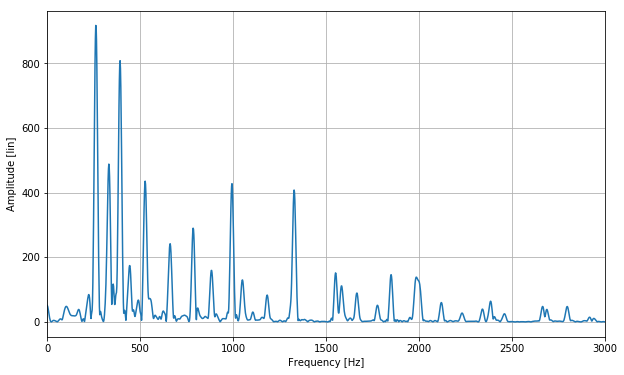

In [3]:
def F_getSpectre(data_v, L_n, Nfft, sr_hz, dF = None, fmin= 50, fmax = 900, H = 4):
    """
    inputs:
        - data_v: signal
        - L_n: window duration in samples
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitudes
    """
    
    ### START CODE HERE ### 
    
    dF = sr_hz/len(data_v)
    data_v = data_v[0:L_n]
    # construct the hanning window in order to avoid aliasing
    H = np.hanning(L_n)
    # normalize it
    H /= np.sum(H) * 2
    # apply it to the signal
    S = (data_v * H)
    # compute the FFT
    fftFreq_hz_v, fftAmpl_v = get_Nfft(S, Nfft, sr_hz)
    
    # find where to cut
    where_to_cut = np.argmax(fftFreq_hz_v) + 1
    
    fftFreq_hz_v = fftFreq_hz_v[:where_to_cut]
    fftAmpl_v = fftAmpl_v[:where_to_cut]
    ### END CODE HERE ###
        
    plt.figure(figsize=(10, 6))
    tpt_tools.F_plot1(fftFreq_hz_v, fftAmpl_v, 'Frequency [Hz]', 'Amplitude [lin]')
    plt.xlim((0,3000))

    return fftFreq_hz_v, fftAmpl_v

fftFreq_hz_v, fftAmpl_v = F_getSpectre(data_v, L_n, Nfft, sr_hz)


### Test 
Pour le signal audioFile = './_audio/A3C4E4G4_piano.wav' vous devriez obtenir

<IMG SRC='./_images/TP_multiPitch_01.png' width=600/>

## Calcul du produit spectral

Le produit spectral $P$ sera codé dans un vecteur de longueur $R$, couvrant l'intervalle $[0, R-1]$.
La fréquence maximale intervenant dans le calcul de $P$ sera donc $H \frac{R-1}{N_{fft}} Fs$.
En déduire, en fonction de $N_{fft}$, la valeur maximale de $R$ qui garantit de ne pas dépasser la fréquence de Nyquist ($\frac{Fs}{2}$).
Calculer ensuite $P$ en fonction de $|X|$.

## Recherche du maximum du produit spectral

Déterminer les valeurs entières $N_{min}$ et $N_{max}$ qui correspondent à l’intervalle $[F_{min},F_{max}]$ (on veillera à ce que $N_{max}$ reste inférieur à $R$).
Rechercher le maximum de $P$ sur l’intervalle $[N_{min},N_{max}]$, et en déduire la valeur de la fréquence fondamentale $F0$.
On testera la fonction de détection de la fréquence fondamentale sur des signaux monophoniques (par exemple A4\_piano.wav ou E4\_oboe.wav).

In [4]:
# Helper function for finding k such as X(k) = f
# Returns the indice for the given frequency
def lookForClosest(value, vector, Fe, Nfft):
    '''
    INPUTS:
        - value : value of the frequency we are looking for (in hertz).
        - vector : vector containing the frequencies of the sound we are working on (in hertz).
        - Fe : sampling rate (in hertz).
        - Nfft : the N used for the FFT (in samples).
    
    OUTPUTS :
        - i : the indice in the vector corresponding to the closest frequency from value
    '''
    
    if value == 0:
        return 0
    
    # initializing with the theoretical value
    i = int(round(Nfft//(Fe/value)))
    
    # if the frequency is not present in the vector we return the closest - the last one
    if i >= len(vector):
        return (len(vector) -1)
    
    # we use a quadratic loss
    s = (vector[i] - value)**2
    
    # in case there issue with flooring we look at the neighborhood
    for k in range(i+1, len(vector)):
        s_temp = (vector[k] - value)**2
        if s_temp <= s:
            s = s_temp
            i = k
        else :
            break
            
    for k in range(0, i):
        s_temp = (vector[k] - value)**2
        if s_temp <= s:
            s = s_temp
            i = k
        else :
            break
   
    return i

332.03125


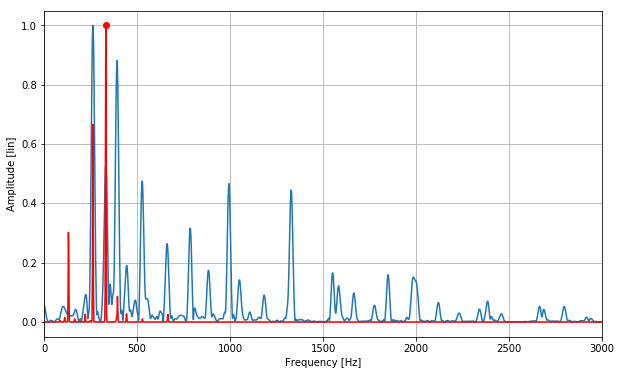

In [5]:
def F_getSpectralProduct(fftFreq_hz_v, fftAmpl_v, H, fmin_hz, fmax_hz, Nfft, sr_hz):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude 
        - H: number of times the spectrum is decimated
        - fmin_hz: minimum frequency in Hz to look for F0
        - fmax_hz: maximum frequency in Hz to look for F0
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - spFreq_hz_v: vector containing the SpectralProduct frequencies in Hz
        - spAmpl_v: vector containing the SpectralProduct amplitudes 
        - f0_hz: estimated F0 in Hz
    """
    
    ### START CODE HERE ###
    
    R = Nfft//(2*H)
    spFreq_hz_v = []
    spAmpl_v = []
    for f in range(R):
        # for every frequency we compute the spectral product
        spAmpl_v.append(1)
        spFreq_hz_v.append(fftFreq_hz_v[f])
        for h in range(1, H+1):
            # for every h, we multiply
            spAmpl_v[f] *= fftAmpl_v[lookForClosest(fftFreq_hz_v[f]*h, fftFreq_hz_v, sr_hz, Nfft)]
    
    # find the range where we look for f_0
    nMin = lookForClosest(fmin_hz, fftFreq_hz_v, sr_hz, Nfft)
    nMax = lookForClosest(fmax_hz, fftFreq_hz_v, sr_hz, Nfft)
        
    # find the argmax for this range
    f0_hz = 0
    maxAmp = np.amax(spAmpl_v[nMin:nMax])
    for i in range(nMin, nMax):
        if spAmpl_v[i] >= maxAmp:
            f0_hz = fftFreq_hz_v[i]
            break
    
    print(f0_hz)
        
    ### END CODE HERE ###
    
    plt.figure(figsize=(10,6))
    tpt_tools.F_plot1(fftFreq_hz_v, fftAmpl_v/np.max(fftAmpl_v), 'Frequency [Hz]', 'Amplitude [lin]')
    plt.plot(spFreq_hz_v, spAmpl_v/np.max(spAmpl_v), 'r')
    plt.xlim((0,3000))
    plt.plot(f0_hz, 1, 'ro')

    return spFreq_hz_v, spAmpl_v, f0_hz

spFreq_hz_v, spAmpl_v, f0_hz = F_getSpectralProduct(fftFreq_hz_v, fftAmpl_v, H, fmin_hz, fmax_hz, Nfft, sr_hz)



### Test 
Pour le signal audioFile = './_audio/A3C4E4G4_piano.wav' vous devriez obtenir

<IMG SRC='./_images/TP_multiPitch_02.png' width=600/>

# Soustraction du son correspondant à la fréquence fondamentale détectée

## Détection des harmoniques

Dans un premier temps, il s’agit de détecter les harmoniques du son considéré.
La procédure qui est proposée consiste à rechercher le maximum du spectre autour de chaque harmonique théorique de fréquence $f_k = k \cdot F0$.

L’intervalle de recherche autour de chaque harmonique est donné par $[f_{kmin}:f_{kmax}]$. 
On pourra choisir $f_{kmin} = (1-\alpha)*f_{inharmo}$ et $f_{kmax} = (1+\alpha)*f_{inharmo}$ avec $f_{inharmo} = k * F0 * \sqrt{1+(k^2-1) * \beta}$ où $\beta$ est le coefficient d’inharmonicité (ce qui correspond à un bon modèle d’inharmonicité dans le cas du piano).
On pourra par ailleurs appliquer cette recherche également pour $k$ = 1 afin d’affiner l’estimation de F0.
Quel choix de $\alpha$, $\beta$ vous parait judicieux pour le piano ? pour le hautbois ? 
Ce modèle de recherche des harmoniques vous parait-il judicieux ? justifier.

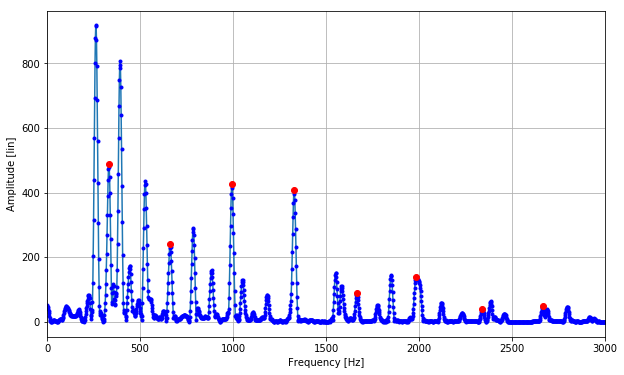

In [6]:
def F_getHarmonics(fftFreq_hz_v, fftAmpl_v, f0_hz, Nfft, sr_hz):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude 
        - f0_hz: estimated F0 in Hz
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - harmoFreq_k_v: vector containing the Harmonics frequencies in Hz
        - harmoAmpl_v:  vector containing the Harmonic amplitudes
    """
    
    ### START CODE HERE ###   
    
    # Il faut choisir un Beta qui corresponde au coefficient d'inharmonicité du son recherché, soit ici une valeur 
    # relativement moyenne pour une corde de piano.
    # Si le facteur d'inharmonicité est parfaitement choisi (très difficile) on de devrait théoriquement pouvoir
    # choisir alpha = 0, or, moins on peut faire confiance en notre Beta, plus on devrait prendre un Alpha grand.
    # Nous nous proposons d'effectuer une recherche sur l'intervalle [-quart de ton, + quart de ton] autours de 
    # f_inharmo, ce qui correspond intuitivement au fait de chercher le plus grand partiel sans prendre le risque 
    # de prendre le partiel d'une autre f0. Ces valeurs sont definies en debut de programme afin de pouvoir les changer
    # au momen de changer d'exemple sonore.
    # L'utilisation de cette methode de recherche ne permet pas d'être générique : on doit définir à la main 
    # Beta et Alpha qui, de plus, ne dependent pas seulement de l'instrument (change pour chaque corde du piano)
    # par exemple. Elle semble, de ce fait, peu judicieuse pour faire de la detection de pitch.
    
    # harmoFreq_k_v contains frequencies in hertz as said in the definitions of the functions.
    
    harmoFreq_k_v = []
    harmoAmpl_v = []
    
    for k in range(1, int(np.max(fftFreq_hz_v)/f0_hz)):
        f_inharmo = k * f0_hz * np.sqrt(1 + (k**2 - 1) * Beta)
        
        # defining the interval in wich we wil be looking
        starting_indice = lookForClosest((1-Alpha)*f_inharmo, fftFreq_hz_v, sr_hz, Nfft)
        ending_indice = lookForClosest((1+Alpha)*f_inharmo, fftFreq_hz_v, sr_hz, Nfft) + 1
        
        # computing the maximal amplitude in the interval
        indice_max = np.argmax(fftAmpl_v[starting_indice : ending_indice]) + starting_indice
        
        # we add the corresponding frequency and amplitude
        harmoFreq_k_v.append(fftFreq_hz_v[indice_max])
        harmoAmpl_v.append(fftAmpl_v[indice_max])
    
    harmoFreq_k_v = np.asarray(harmoFreq_k_v)
    harmoAmpl_v = np.asarray(harmoAmpl_v)
    ### END CODE HERE ###   
    
    plt.figure(figsize=(10,6))
    tpt_tools.F_plot1(fftFreq_hz_v, fftAmpl_v, 'Frequency [Hz]', 'Amplitude [lin]')
    plt.plot(fftFreq_hz_v, fftAmpl_v, 'b.')
    plt.plot(harmoFreq_k_v, harmoAmpl_v, 'ro')
    plt.xlim((0,3000))

    return harmoFreq_k_v, harmoAmpl_v
    
harmoFreq_k_v, harmoAmpl_v = F_getHarmonics(fftFreq_hz_v, fftAmpl_v, f0_hz, Nfft, sr_hz)


### Test 
Pour le signal audioFile = './_audio/A3C4E4G4_piano.wav' vous devriez obtenir

<IMG SRC='./_images/TP_multiPitch_03.png' width=600/>

## Suppression des harmoniques

Il s’agit ensuite de supprimer la totalité des harmoniques correspondant à un son donné. 
Pour cela, il suffit de calculer la largeur théorique d’un pic spectral en fonction de la largeur de la fenêtre d’analyse utilisée.
Ensuite, on annule l’ensemble des bins fréquentiels correspondant à chaque harmonique (i.e sur l’intervalle $[k1 : k2]$).

En raison de la technique d’estimation de la fréquence fondamentale utilisée, la mise à zéro des harmoniques perturbe les itérations ultérieures de l’algorithme et on remplacera avantageusement la mise à zéro par le forçage des valeurs du spectre autour de chaque harmonique au minimum du spectre sur cet intervalle ($|X_k(k1 : k2)| = \min(|X_k(k1 : k2))|$).

## Suppression des harmoniques avec application du principe du "spectral smoothness"

Afin de mieux discerner les sons qui sont en relation harmonique (et notamment les sons à l’octave) il est préférable de ne pas soustraire totalement un son de la mixture, mais d’essayer de ne soustraire que sa contribution au niveau de chaque harmonique.
Pour cela, on utilise le principe de la continuité de l’enveloppe spectrale ("spectral smoothness") qui consiste à calculer un spectre harmonique lissé où l’amplitude au niveau de chaque harmonique $f_k$ est remplacée par la moyenne des amplitudes des harmoniques $f_{k-1}$, $f_k$ et $f_{k+1}$.
Ensuite, la soustraction spectrale consiste à:

– Si la valeur du spectre au niveau de l’harmonique est inférieure à celle obtenue sur le spectre harmonique lissé 
    - alors forcer les valeurs du spectre autour de chaque harmonique au minimum du spectre sur cet intervalle ($|X_k(k1 : k2)| = \min(|X_k(k1 : k2))|$)

– Si la valeur du spectre au niveau de l’harmonique est supérieure à celle obtenue sur le spectre harmonique lissé 
    - alors forcer les valeurs du spectre autour de chaque harmonique à la différence entre le spectre et le spectre lissé sur cet intervalle $[k_1 : k_2]$ 

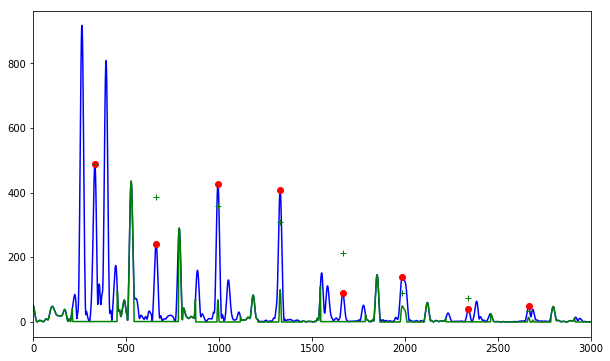

In [7]:
def M_cancelHarmonics(fftFreq_hz_v, fftAmpl_v, harmoFreq_k_v, harmoAmpl_v, L_sec, Nfft, sr_hz):
    """
    inputs:
       - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude 
        - harmoFreq_k_v: vector containing the Harmonics frequencies in Hz
        - harmoAmpl_v:  vector containing the Harmonic amplitudes
        - L_sec: window duration in seconds
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - fftAmplSubtract_v (N/2+1,):  vector containing the FFT amplitude with amplitudes canceled at harmonic positions
    """
 

    Cw = 2.0 # === for a hanning window
    Bw_hz = 12*Cw/(L_sec)
    Bw_k = np.int(Bw_hz/sr_hz*Nfft)
    Bw_k = Bw_k +Bw_k % 2
    
    ### START CODE HERE ###
    
    # Compute the smoothed amps
    harmoAmplSmooth_v= []
    for i in range(len(harmoAmpl_v)):
        # if we don't have definition pb for k =1 and k = n
        if i > 0 and i < len(harmoAmpl_v)-1:
            harmoAmplSmooth_v.append((harmoAmpl_v[i-1]+ harmoAmpl_v[i] + harmoAmpl_v[i+1])/3)
        
        # else we guess what we should do ...
        elif i == 0:
            harmoAmplSmooth_v.append(harmoAmpl_v[i])
        elif i == len(harmoAmpl_v)-1:
            harmoAmplSmooth_v.append(harmoAmpl_v[i])
        else:
            print(i)
            raise ValueError("Conception error in if/else, should not append.")
                
    fftAmplSubtract_v = np.copy(fftAmpl_v)
    
    for f_i in range(len(harmoFreq_k_v)):
        # find the bandwith of the frequency
        starting_indice = lookForClosest(harmoFreq_k_v[f_i] - Bw_hz//2, fftFreq_hz_v, sr_hz, Nfft)
        ending_indice = lookForClosest(harmoFreq_k_v[f_i] + Bw_hz//2, fftFreq_hz_v, sr_hz, Nfft) +1
        
        if harmoAmpl_v[f_i] <= harmoAmplSmooth_v[f_i]:
            if len(fftAmpl_v[starting_indice:ending_indice]) > 0:
                fftAmplSubtract_v[starting_indice:ending_indice] = np.min(fftAmpl_v[starting_indice:ending_indice])
            else:
                fftAmplSubtract_v[starting_indice:ending_indice] = 0
                
        elif harmoAmpl_v[f_i] > harmoAmplSmooth_v[f_i]:
            fftAmplSubtract_v[starting_indice:ending_indice] -= harmoAmplSmooth_v[f_i]

        
    for i in range(len(fftAmplSubtract_v)):
        if fftAmplSubtract_v[i] < 0:
            fftAmplSubtract_v[i] = 0
            
    ### END CODE HERE ###    
    
    
    plt.figure(figsize=(10,6))
    plt.plot(fftFreq_hz_v, fftAmpl_v, 'b-')
    plt.plot(harmoFreq_k_v, harmoAmpl_v, 'ro')
    plt.plot(harmoFreq_k_v, harmoAmplSmooth_v, 'g+')
    plt.plot(fftFreq_hz_v, fftAmplSubtract_v, 'g-')
    plt.xlim((0,3000))


    return fftAmplSubtract_v



fftAmplSubtract_v = M_cancelHarmonics(fftFreq_hz_v, fftAmpl_v, harmoFreq_k_v, harmoAmpl_v, L_sec, Nfft, sr_hz)

### Test 
Pour le signal audioFile = './_audio/A3C4E4G4_piano.wav' vous devriez obtenir

<IMG SRC='./_images/TP_multiPitch_04.png' width=600/>

## Critère d’arrêt

Les étapes précédentes sont ensuite itérées tant qu’un certain critère d’arrêt n’est pas vérifié.
Déterminer un critère d’arrêt qui vous permet d’arrêter l’itération lorsque le bon nombre de notes a été trouvé.
On testera l’algorithme sur les différents accords proposés.

332.03125
332.03125 0.11615725932151333
496.09375
496.09375 0.04025366164930805
52.734375
52.734375 0.0005668715263156282


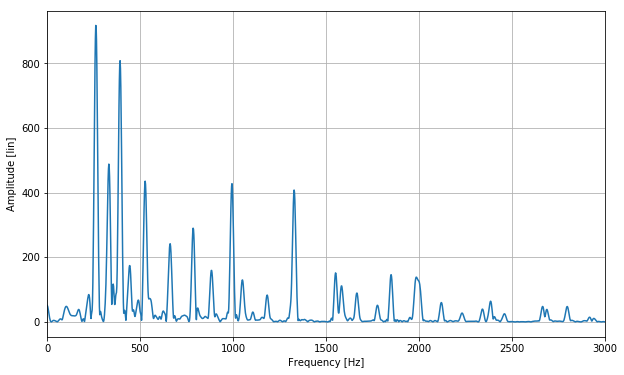

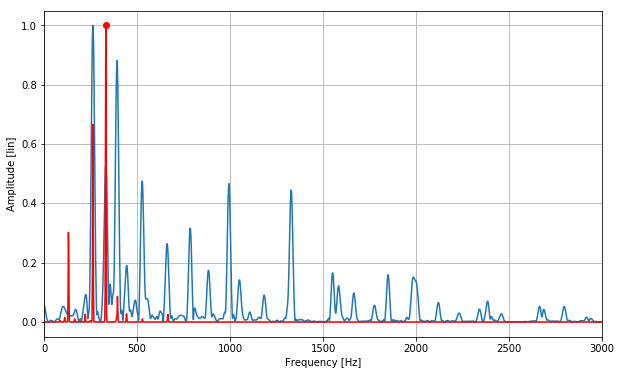

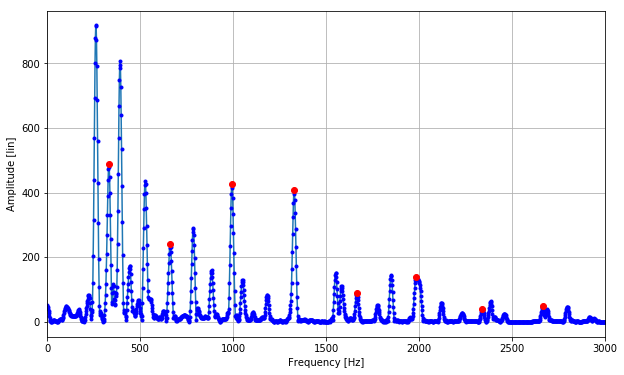

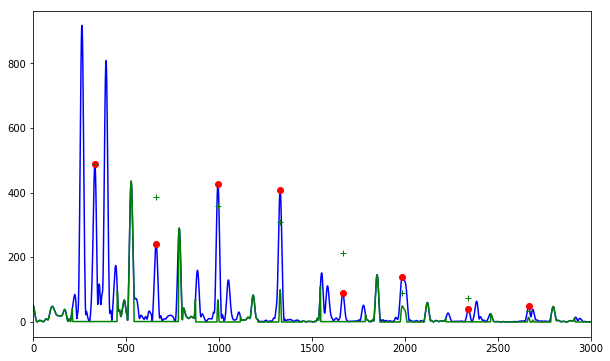

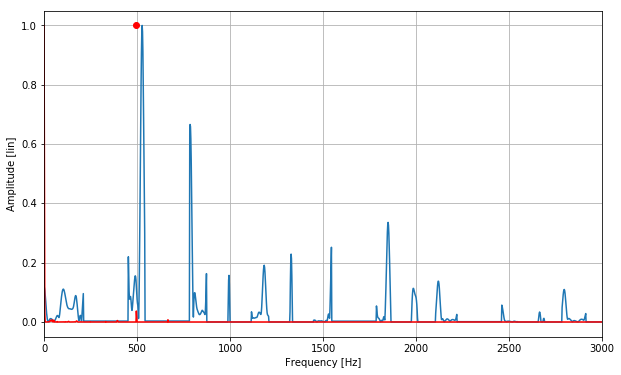

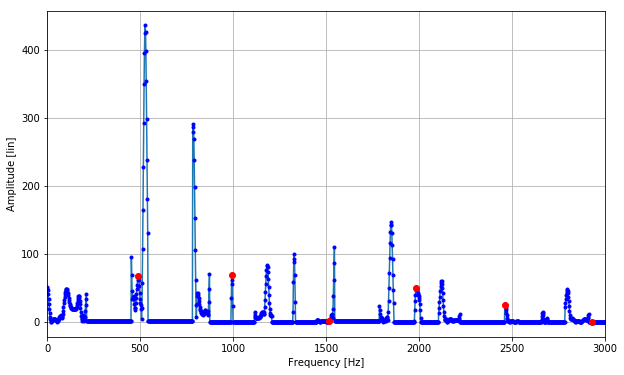

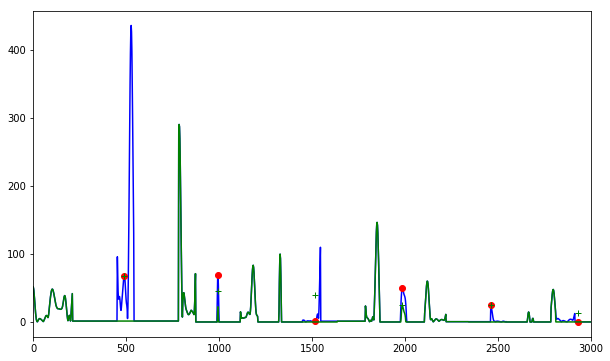

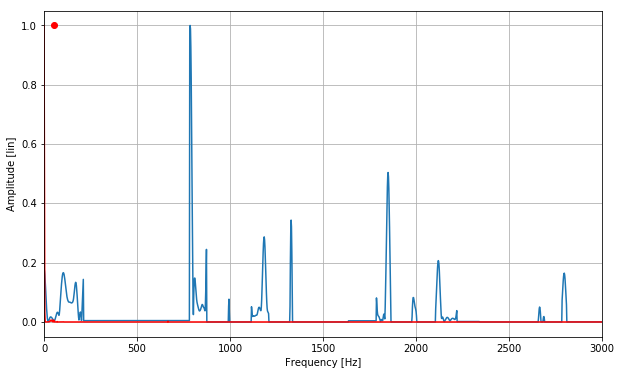

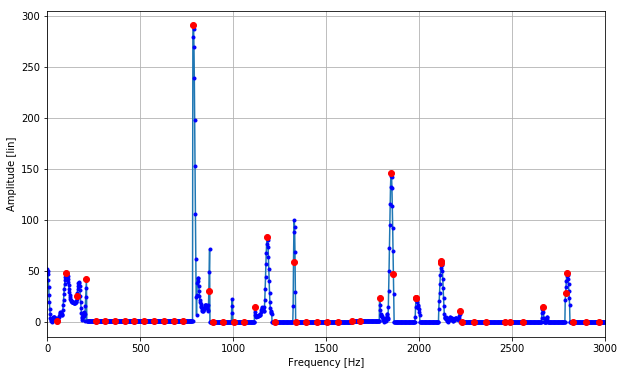

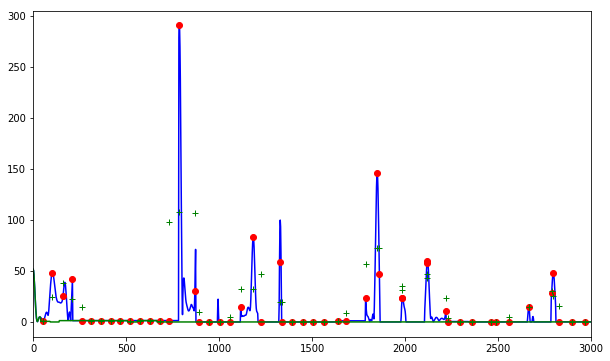

In [8]:
fftFreq_hz_v, fftAmpl_v = F_getSpectre(data_v, L_n, Nfft, sr_hz)

energy_init = np.dot(fftAmpl_v, fftAmpl_v)
energy_ratio = 1
# this one seems good as it returns good results for most of the examples (the minor seventh chord looks difficult to find)
enery_threshold = 0.01

count = 0
while (energy_ratio > enery_threshold) & (count < 10):
    spFreq_hz_v, spAmpl_v, f0_hz = F_getSpectralProduct(fftFreq_hz_v, fftAmpl_v, H, fmin_hz, fmax_hz, Nfft, sr_hz)
    harmoFreq_k_v, harmoAmpl_v = F_getHarmonics(fftFreq_hz_v, fftAmpl_v, f0_hz, Nfft, sr_hz)
    fftAmpl_v = M_cancelHarmonics(fftFreq_hz_v, fftAmpl_v, harmoFreq_k_v, harmoAmpl_v, L_sec, Nfft, sr_hz)
    energy_ratio = np.dot(fftAmpl_v, fftAmpl_v) / energy_init
    print("{} {}".format(f0_hz, energy_ratio))
    count += 1

# Bibliographie

- [1] A.P. Klapuri. Multipitch estimation and sound separation by the spectral smoothness principle. In Procee- dings of IEEE International Conference on Acoustics, Speech and Signal Processing, ICASSP, May 2001.
- [2] A.P. Klapuri. Multiple fundamental frequency estimation by harmonicity and spectral smoothness. IEEE Trans. Speech and Audio Processing, 11(6) :804–816, 2003.